In [179]:
from collections import defaultdict
import pyspark
from pyspark.sql import SparkSession
import pyspark.pandas as ps
from pyspark.sql.functions import split, col
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt

sc = (
    SparkSession
    .builder
    .master("local[2]")
    .appName("hw05")
    .getOrCreate()
)


In [187]:
dtrain = (
    sc
    .read
    .format("csv")
    .option("header",True)
    .option("quote", "\"")
    .option("escape", "\"")
    .option("multiline", True)
    .load("file:///home/jovyan/work/train.csv")
    .withColumn("toxic",col("toxic").cast("integer"))
    .withColumn("severe_toxic",col("severe_toxic").cast("integer"))
    .withColumn("obscene",col("obscene").cast("integer"))
    .withColumn("threat",col("threat").cast("integer"))
    .withColumn("insult",col("insult").cast("integer"))
    .withColumn("identity_hate",col("identity_hate").cast("integer"))
)


dtest = (
    sc
    .read
    .format("csv")
    .option("header",True)
    .option("quote", "\"")
    .option("escape", "\"")
    .option("multiline", True)
    .load("file:///home/jovyan/work/test.csv")
    # .withColumn("toxic",col("toxic").cast("integer"))
    # .withColumn("severe_toxic",col("severe_toxic").cast("integer"))
    # .withColumn("obscene",col("obscene").cast("integer"))
    # .withColumn("threat",col("threat").cast("integer"))
    # .withColumn("insult",col("insult").cast("integer"))
    # .withColumn("identity_hate",col("identity_hate").cast("integer"))
)

dlabels = (
    sc
    .read
    .format("csv")
    .option("header",True)
    .load("file:///home/jovyan/work/test_labels.csv")
    .withColumn("toxic",col("toxic").cast("integer"))
    .withColumn("severe_toxic",col("severe_toxic").cast("integer"))
    .withColumn("obscene",col("obscene").cast("integer"))
    .withColumn("threat",col("threat").cast("integer"))
    .withColumn("insult",col("insult").cast("integer"))
    .withColumn("identity_hate",col("identity_hate").cast("integer"))
)

dtest = dtest.join(dlabels, "id")

targets = [
    'toxic', 'severe_toxic', 'obscene',
    'threat', 'insult', 'identity_hate',
]

metrics = defaultdict(dict)
n_feats = 5
for n_feats in [5, 10, 20, 30, 50, 75, 100]:
    tokenizer = Tokenizer(inputCol="comment_text", outputCol="comment_words")
    dtrain2 = tokenizer.transform(dtrain)
    hashingTF = HashingTF(inputCol="comment_words", outputCol="feats_raw", numFeatures=n_feats)
    dtrain2 = hashingTF.transform(dtrain2)
    idf = IDF(inputCol="feats_raw", outputCol="feats")
    idfModel = idf.fit(dtrain2)
    dtrain2 = idfModel.transform(dtrain2)
    
    # target = "toxic"
    for target in targets:
        lr = LogisticRegression(labelCol=target).setFeaturesCol("feats")
        lrn = lr.fit(dtrain2)
        dtest2 = dtest[dtest[target]!=-1]#.show(10)
        dtest2 = tokenizer.transform(dtest2)
        dtest2 = hashingTF.transform(dtest2)
        dtest2 = idfModel.transform(dtest2)
        dtest2 = lrn.transform(dtest2)
        bce = BinaryClassificationEvaluator(labelCol=target)
        auroc = bce.evaluate(dtest2)
        metrics[target][n_feats] = auroc

In [188]:
metrics

defaultdict(dict,
            {'toxic': {5: 0.6550254920094833,
              10: 0.6609071429819509,
              20: 0.6805580630872279,
              30: 0.7054379058003177,
              50: 0.7023592610973597,
              75: 0.7427806588862823,
              100: 0.7588961337832818},
             'severe_toxic': {5: 0.5554468776650233,
              10: 0.6323298195687617,
              20: 0.6550152607146377,
              30: 0.6325465661368112,
              50: 0.6982599277103055,
              75: 0.761472607881427,
              100: 0.7761570379431182},
             'obscene': {5: 0.6560260878384782,
              10: 0.6807442002889119,
              20: 0.6976978048157504,
              30: 0.7278128217515598,
              50: 0.7316303307725864,
              75: 0.7797362172381661,
              100: 0.7809359849868672},
             'threat': {5: 0.6976945911719313,
              10: 0.6939558985367098,
              20: 0.7058392086057967,
              30: 0.690

max=0.7588961337832818


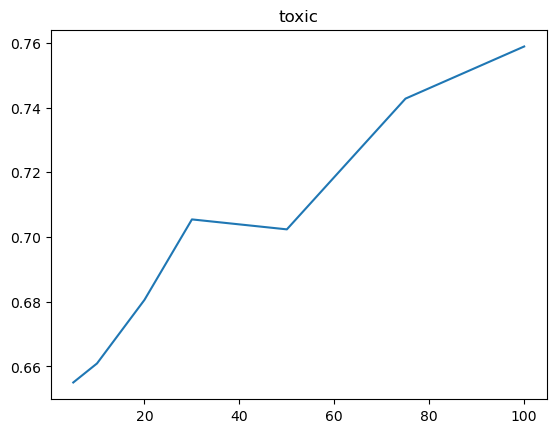

In [195]:
target = "toxic"
x,y = zip(*metrics[target].items())
plt.plot(x,y)
plt.title(target)
print(f"max={max(y)}")

max=0.7761570379431182


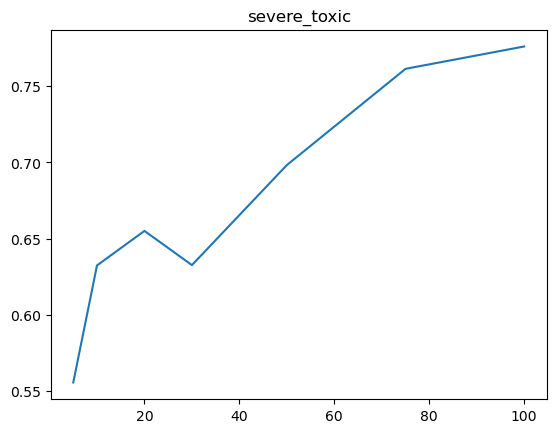

In [196]:
target = 'severe_toxic'# 'obscene', 'threat', 'insult', 'identity_hate',
x,y = zip(*metrics[target].items())
plt.plot(x,y)
plt.title(target)
print(f"max={max(y)}")

max=0.7809359849868672


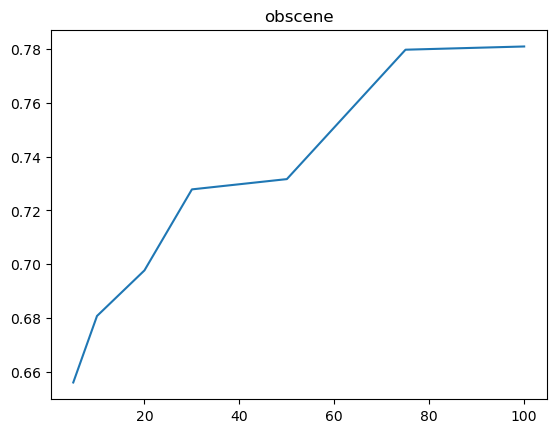

In [197]:
target = 'obscene'#, 'threat', 'insult', 'identity_hate',
x,y = zip(*metrics[target].items())
plt.plot(x,y)
plt.title(target)
print(f"max={max(y)}")

max=0.800594537117027


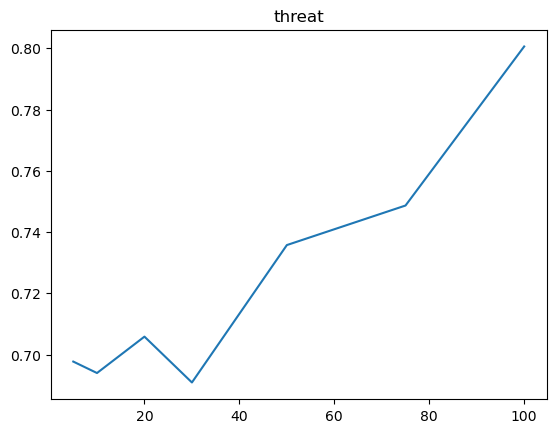

In [198]:
target = 'threat'#, 'insult', 'identity_hate',
x,y = zip(*metrics[target].items())
plt.plot(x,y)
plt.title(target)
print(f"max={max(y)}")

max=0.7828370263032911


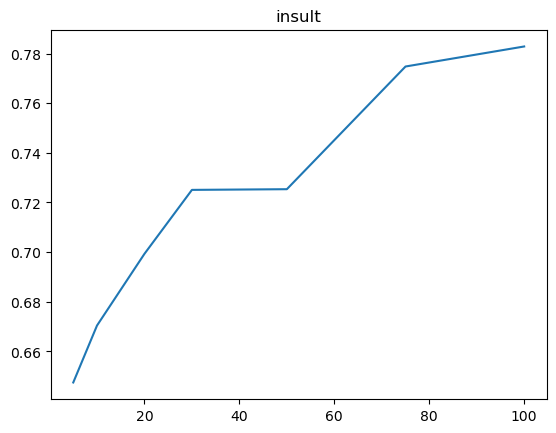

In [199]:
target = 'insult'#, 'identity_hate',
x,y = zip(*metrics[target].items())
plt.plot(x,y)
plt.title(target)
print(f"max={max(y)}")

max=0.7478300222140355


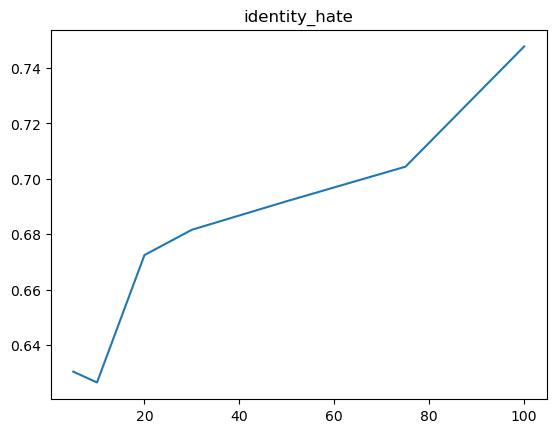

In [200]:
target = 'identity_hate'
x,y = zip(*metrics[target].items())
plt.plot(x,y)
plt.title(target)
print(f"max={max(y)}")

# Выводы
1. Для каждого таргета метрика AUROC растет с увеличением numFeatures пока не достигнет оптимального значения numFeatures, затем падает. 
2. У каждого таргета свое оптимальное значение numFeatures